# Research Question 4: 

Is there a bias within the quotes and sentiment or rating of a movie w.r.t gender, ethnicity, etc.?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, pearsonr, ttest_ind, kstest
import statsmodels.api as sm
import statsmodels.formula.api as smf
from wikidata.client import Client
import pickle

## Are quotes in quotebank regarding movies biased?

We first aim to analyze how different genders are represented in the quotes regarding the movies. For this, we chose the highly represented top-quoted movies (about 10 per year), to get a meaningful number of quotes per movie, and also to analyze movies that are so popular that they potentially reach big parts of society (blockbusters), in order to analyze who makes quotes about his opinion about movies in general, and not just niche movies with a very limited interest group. 

In [2]:
df_quotes = pd.read_pickle('./exploratory/data/Quotebank_sentiment.pkl')
df_quotes.head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID,AFINN_label,AFINN_score,VADER_label,VADER_score,BERT_label,BERT_score,positive_BERT_score,scaledReverted_BERT_score
0,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,The Hunger Games: Mockingjay - Part 2,1751,POSITIVE,0.500000,POSITIVE,0.3612,NEGATIVE,0.989802,0.010198,-0.541032
1,I want to clarify my interview on the `Charlie...,George Lucas,"[Q38222, Q1507803]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens,6724,POSITIVE,0.165563,POSITIVE,0.9910,POSITIVE,0.999293,0.999293,0.787788
2,Is Daredevil joining the Avengers for Infinity...,Scott Davis,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619...",2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,Avengers: Age of Ultron,692,NEGATIVE,-0.153846,NEGATIVE,-0.6369,NEGATIVE,0.833872,0.166128,-0.208302
3,"They were saying, `Well, since when has Star W...",J.J. Abrams,[Q188137],2015-12-21,1,"[[J.J. Abrams, 0.5868], [None, 0.2584], [Lupit...",[http://rssfeeds.usatoday.com/~/129385923/0/us...,Star Wars: Episode VII - The Force Awakens,2394,POSITIVE,0.000000,NEGATIVE,-0.3612,NEGATIVE,0.991336,0.008664,-0.559515
4,You meet new characters and you learn about Ha...,Kevin Feige,[Q515161],2015-05-06,1,"[[Kevin Feige, 0.9108], [None, 0.0782], [Scott...",[http://www.digitaltrends.com/movies/ant-man-m...,Avengers: Age of Ultron,8789,NEGATIVE,-0.011111,POSITIVE,0.1901,POSITIVE,0.999218,0.999218,0.776419


In [3]:
df_quotes.shape

(70180, 17)

Our first approach to getting the gender of a speaker was a specialized python library that was able to estimate the gender of a speaker based on the first name, called `gender-guesser`. While it worked quite well for a majority of names, we found 2 shortcomings: First, it wasn't able to deal with all speakers we had available, as e.g. J.J. of J.J. Abrams couldn't be matched. Also, it supported an only binary approach to gender, which we also wanted to extend to also include non-binary genders. 

Hence, we instead decided to extract the gender from the given wikidata. For this, we first read the data in, and then check for the given qids for gender. We then use the library `wikidata` to get meaningful names for the gender qids. 

In [4]:
df_wikidata = pd.read_parquet('exploratory/data/speaker_attributes.parquet')

In [5]:
df_wikidata = df_wikidata.set_index('id')

In [6]:
df_wikidata.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion
id,,,,,,,,,,,,,,
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,George Washington,"[Q698073, Q697949]",item,[Q682443]
Q42,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Douglas Adams,None,item,None
Q1868,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Paul Otlet,None,item,None
Q207,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
Q297,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Diego Velázquez,None,item,None


In [7]:
df_wikidata = df_wikidata.dropna(subset=['gender'])

In [8]:
df_wikidata['gender'] = df_wikidata['gender'].apply(lambda x: x[0])

In [9]:
df_wikidata['gender'].unique()

array(['Q6581097', 'Q6581072', 'Q1052281', 'Q2449503', 'Q48270',
       'Q1097630', 'Q12964198', 'Q189125', 'Q15145779', 'Q301702',
       'Q179294', 'Q27679766', 'Q18116794', 'Q859614', 'Q44148',
       'Q1289754', 'Q106299064', 'Q27679684', 'Q15145778', 'Q52261234',
       'Q207959', 'Q43445', 'Q505371', 'Q7130936', 'Q96000630',
       'Q1984232', 'Q93954933', 'Q746411', 'Q48279', 'Q3177577',
       'Q1775415', 'Q6636'], dtype=object)

In [10]:
client = Client()
qid_to_gender = dict()
for qid in df_wikidata['gender'].unique():
    if qid is not None:
        entity = client.get(qid, load=True)
        try:
            qid_to_gender[qid] = entity.data['labels']['en']['value']
        except:
            print(qid)
qid_to_gender

{'Q6581097': 'male',
 'Q6581072': 'female',
 'Q1052281': 'transgender female',
 'Q2449503': 'transgender male',
 'Q48270': 'non-binary',
 'Q1097630': 'intersex',
 'Q12964198': 'genderqueer',
 'Q189125': 'transgender person',
 'Q15145779': 'cisgender female',
 'Q301702': 'two-spirit',
 'Q179294': 'eunuch',
 'Q27679766': 'transmasculine',
 'Q18116794': 'genderfluid',
 'Q859614': 'bigender',
 'Q44148': 'male organism',
 'Q1289754': 'neutrois',
 'Q106299064': 'Erkek',
 'Q27679684': 'transfeminine',
 'Q15145778': 'cisgender male',
 'Q52261234': 'neutral sex',
 'Q207959': 'androgyny',
 'Q43445': 'female organism',
 'Q505371': 'agender',
 'Q7130936': 'pangender',
 'Q96000630': 'X-gender',
 'Q1984232': 'shemale',
 'Q93954933': 'demiboy',
 'Q746411': 'kathoey',
 'Q48279': 'third gender',
 'Q3177577': 'muxe',
 'Q1775415': 'feminine',
 'Q6636': 'homosexuality'}

In the following, we decided to keep male and female, and summarize other genders with a 'diverse' label. We so apply this to our dataframe of wikipedia properties.

In [11]:
df_wikidata['gender'] = df_wikidata['gender'].apply(lambda x: 'male' if x == 'Q6581097' else 'female' if x == 'Q6581072' else 'diverse')

To further investigate, we create a dataframe to map our shared_IDs with their gender. We give these shared_IDs to a set of qids referring to the same person (e.g. Donald Trump, President Trump, etc.). To get the gender, we decided to check all qids and stop after the first match (assuming that each article gives the same gender to a person, if any). 

In [12]:
map_gender = df_quotes[['shared_ID', 'qids']].drop_duplicates(subset=['shared_ID'])
map_gender.head()

,shared_ID,qids
0,1751,[Q16843606]
1,6724,"[Q38222, Q1507803]"
2,692,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619..."
3,2394,[Q188137]
4,8789,[Q515161]


In [13]:
map_gender.shape

(13440, 2)

In [14]:
def get_gender(row):
    for qid in row['qids']:
        try:
            gender = df_wikidata.loc[qid, 'gender']
            row['gender'] = gender
            return row
        except KeyError:
            continue
    row['gender'] = None
    return row
map_gender = map_gender.apply(get_gender, axis=1)

In [15]:
map_gender['gender'].value_counts()

male       10639
female      2555
diverse       35
Name: gender, dtype: int64

In [16]:
map_gender = map_gender.set_index('shared_ID')

In [17]:
df_quotes = df_quotes.merge(map_gender, how='left', left_on='shared_ID', right_index=True)
df_quotes.head()

,quotation,speaker,qids_x,date,numOccurrences,probas,urls,movie,shared_ID,AFINN_label,AFINN_score,VADER_label,VADER_score,BERT_label,BERT_score,positive_BERT_score,scaledReverted_BERT_score,qids_y,gender
0,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,The Hunger Games: Mockingjay - Part 2,1751,POSITIVE,0.500000,POSITIVE,0.3612,NEGATIVE,0.989802,0.010198,-0.541032,[Q16843606],female
1,I want to clarify my interview on the `Charlie...,George Lucas,"[Q38222, Q1507803]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens,6724,POSITIVE,0.165563,POSITIVE,0.9910,POSITIVE,0.999293,0.999293,0.787788,"[Q38222, Q1507803]",male
2,Is Daredevil joining the Avengers for Infinity...,Scott Davis,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619...",2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,Avengers: Age of Ultron,692,NEGATIVE,-0.153846,NEGATIVE,-0.6369,NEGATIVE,0.833872,0.166128,-0.208302,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619...",male
3,"They were saying, `Well, since when has Star W...",J.J. Abrams,[Q188137],2015-12-21,1,"[[J.J. Abrams, 0.5868], [None, 0.2584], [Lupit...",[http://rssfeeds.usatoday.com/~/129385923/0/us...,Star Wars: Episode VII - The Force Awakens,2394,POSITIVE,0.000000,NEGATIVE,-0.3612,NEGATIVE,0.991336,0.008664,-0.559515,[Q188137],male
4,You meet new characters and you learn about Ha...,Kevin Feige,[Q515161],2015-05-06,1,"[[Kevin Feige, 0.9108], [None, 0.0782], [Scott...",[http://www.digitaltrends.com/movies/ant-man-m...,Avengers: Age of Ultron,8789,NEGATIVE,-0.011111,POSITIVE,0.1901,POSITIVE,0.999218,0.999218,0.776419,[Q515161],male


In [18]:
df_quotes['gender'].value_counts()

male       57332
female     12176
diverse      127
Name: gender, dtype: int64

<AxesSubplot:ylabel='gender'>

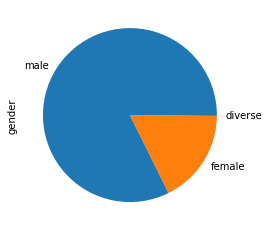

In [19]:
df_quotes['gender'].value_counts().plot.pie()

In [20]:
df_quotes.drop_duplicates('shared_ID')['gender'].value_counts()

male       10639
female      2555
diverse       35
Name: gender, dtype: int64

<AxesSubplot:ylabel='gender'>

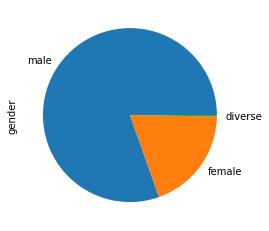

In [21]:
df_quotes.drop_duplicates('shared_ID')['gender'].value_counts().plot.pie()

First interesting finding: A HUGE majority of quotes come from speakers who identify as male, nearly 5 times as much as from women. Other genders are a very small minority. This is pretty outstanding, as one would rather expect male and female to be at about 50 % each. As about 1.2 million of a total of 300 million Americans identify as non-binary (https://williamsinstitute.law.ucla.edu/publications/nonbinary-lgbtq-adults-us/), we would assume the same about 0.4 % of non-binary people, while here we get only 0.1 % of quotes from people identifying as non-binary. We would conclude that mostly women might be underrepresented. 
The same holds for the number of unique speakers. Only 35 are diverse, and there are about 4 times as much women as men.

Another interesting point to check is whether women or men (as the number of diverse quotes and speakers were so low, we continue our investigation on male and female only) tend to be more positive or negative. For this, we first look at the distribution of BERT_scores (the ones used earlier for sentiment analysis), and then check whether these distributions differ. 

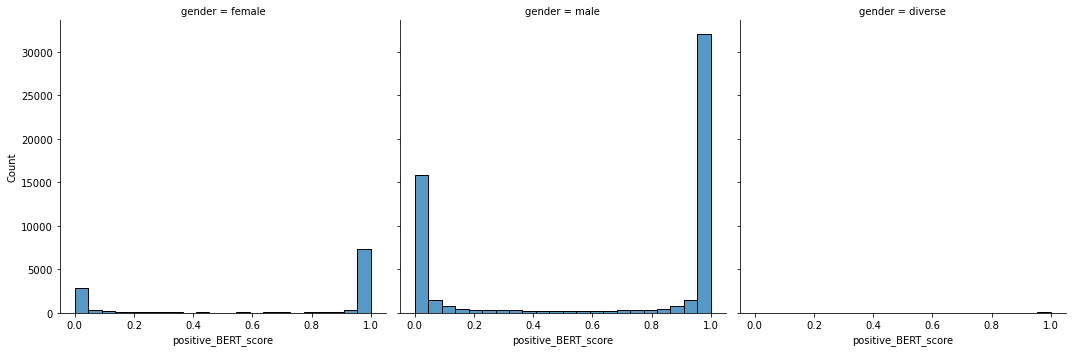

In [22]:
axs = sns.displot(df_quotes, x="positive_BERT_score", col="gender")

In [23]:
df_quotes[df_quotes['gender'] == 'male']['positive_BERT_score'].mean()

0.6407852775468535

In [24]:
df_quotes[df_quotes['gender'] == 'female']['positive_BERT_score'].mean()

0.6820884670783202

In [25]:
df_quotes[df_quotes['gender'] == 'male']['positive_BERT_score'].median()

0.9854506254196167

In [26]:
df_quotes[df_quotes['gender'] == 'female']['positive_BERT_score'].median()

0.9932129383087158

In [27]:
male_scores = df_quotes[df_quotes['gender'] == 'male']['positive_BERT_score']
female_scores = df_quotes[df_quotes['gender'] == 'female']['positive_BERT_score']
kstest(male_scores, female_scores, alternative='two-sided')

KstestResult(statistic=0.06161109192436376, pvalue=1.39040289512341e-33)

We decided for the Kolmogorov-Smirnoff two-sided test to compare the distributions of male and female sentiments. Given our p-value, we can reject the null hypothesis that both distributions are the same. From the higher mean and median of female sentiments, we would deduce that women tend to talk slightly more positive about movies than men do. 

In [28]:
male_movies = df_quotes[df_quotes['gender'] == 'male'].groupby('movie').agg({'positive_BERT_score': 'median', 'quotation': 'count'}).sort_values('positive_BERT_score', ascending=False).rename(columns={'positive_BERT_score': 'median_sentiment', 'quotation': 'no_of_quotes'})
male_medians = male_movies['median_sentiment']
male_movies.head(5)

,median_sentiment,no_of_quotes
movie,,
Fantastic Beasts and Where to Find Them,0.999506,42
Incredibles 2,0.999257,105
Fast & Furious 7,0.998885,21
Fantastic Beasts: The Crimes of Grindelwald,0.998581,193
Frozen II,0.998165,32


In [29]:
female_movies = df_quotes[df_quotes['gender'] == 'female'].groupby('movie').agg({'positive_BERT_score': 'median', 'quotation': 'count'}).sort_values('positive_BERT_score', ascending=False).rename(columns={'positive_BERT_score': 'median_sentiment', 'quotation': 'no_of_quotes'})
female_medians = female_movies['median_sentiment']
female_movies.head(5)

,median_sentiment,no_of_quotes
movie,,
Onward,0.999014,24
Fast & Furious 7,0.998901,2
Incredibles 2,0.998805,20
The Fate of the Furious,0.998448,8
Beauty and the Beast,0.998290,200


In [30]:
male_movies.sort_values('no_of_quotes', ascending=False).head()

,median_sentiment,no_of_quotes
movie,,
Star Wars: Episode VIII - The Last Jedi,0.985657,6818
Star Wars: Episode VII - The Force Awakens,0.992226,6337
Thor: Ragnarok,0.992318,5918
Avengers: Infinity War,0.929187,5212
Captain America: Civil War,0.911468,4181


In [31]:
female_movies.sort_values('no_of_quotes', ascending=False).head()

,median_sentiment,no_of_quotes
movie,,
Wonder Woman,0.998275,2082
Star Wars: Episode VIII - The Last Jedi,0.993809,1466
Star Wars: Episode VII - The Force Awakens,0.993798,1391
Thor: Ragnarok,0.991732,857
Black Panther,0.995702,814


Also, we can see that the movies that more than half of all quotes were positively speaking about deviate quite between men and women, with Fast & Furious 7 and Incredibles 2 being the only movies that appear in both top-5 collections. We are now interested in movies where men and women actually disagree, where majorities are positive for one and negative for the other group. 

In [32]:
diffs = (male_medians - female_medians).dropna().sort_values(ascending=False)
diffs.head(5)

movie
Deadpool          0.800372
Minions           0.197646
Venom             0.193294
Suicide Squad     0.182252
Jurassic World    0.045584
Name: median_sentiment, dtype: float64

In [33]:
diffs.tail(5)

movie
Birds of Prey: And the Fantabulous Emancipation of One Harley Quinn   -0.127122
Mission: Impossible - Fallout                                         -0.170463
Rogue One                                                             -0.306896
Zootopia                                                              -0.630630
Despicable Me 3                                                       -0.878912
Name: median_sentiment, dtype: float64

In this case, a very high (positive) difference of more than 0.5 means that more than 50 % of male quotes were positive, and more than 50 % of female quotes were negative, which apparently is the case for Deadpool. Accordingly, high negative differences that more than 50 % of female quotes were negative, and more than 50 % of female quotes were positive, which is the case for Despicable Me 3 and Zootopia. 

Let's investigate those two extreme movies (Deadpool and Despicable Me 3) a bit further to see what happens there.

In [34]:
df_quotes[(df_quotes['gender'] == 'male') & (df_quotes['movie'].isin(['Deadpool', 'Despicable Me 3']))].groupby('movie').agg({'positive_BERT_score': 'median', 'quotation': 'count'}).sort_values('positive_BERT_score', ascending=False).rename(columns={'positive_BERT_score': 'median_sentiment', 'quotation': 'no_of_quotes'})

,median_sentiment,no_of_quotes
movie,,
Deadpool,0.910349,1401
Despicable Me 3,0.114602,26


In [35]:
df_quotes[(df_quotes['gender'] == 'female') & (df_quotes['movie'].isin(['Deadpool', 'Despicable Me 3']))].groupby('movie').agg({'positive_BERT_score': 'median', 'quotation': 'count'}).sort_values('positive_BERT_score', ascending=False).rename(columns={'positive_BERT_score': 'median_sentiment', 'quotation': 'no_of_quotes'})

,median_sentiment,no_of_quotes
movie,,
Despicable Me 3,0.993513,5
Deadpool,0.109977,110


<AxesSubplot:ylabel='Frequency'>

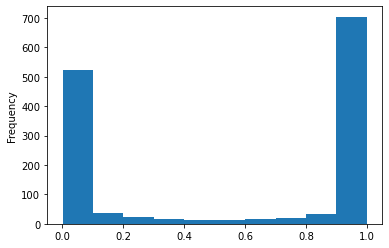

In [36]:
df_quotes[(df_quotes['gender'] == 'male') & (df_quotes['movie'] == 'Deadpool')]['positive_BERT_score'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

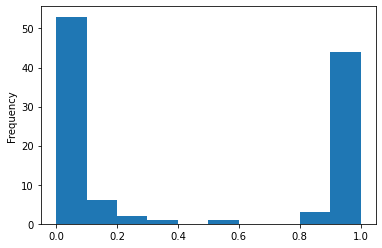

In [37]:
df_quotes[(df_quotes['gender'] == 'female') & (df_quotes['movie'] == 'Deadpool')]['positive_BERT_score'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

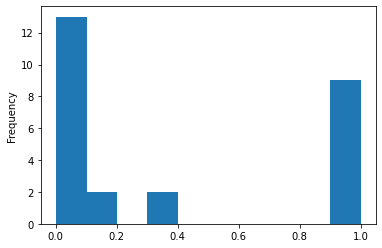

In [38]:
df_quotes[(df_quotes['gender'] == 'male') & (df_quotes['movie'] == 'Despicable Me 3')]['positive_BERT_score'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

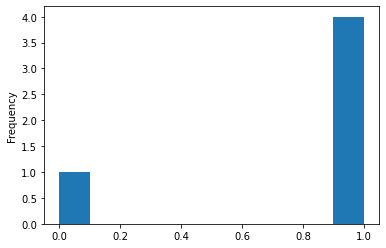

In [39]:
df_quotes[(df_quotes['gender'] == 'female') & (df_quotes['movie'] == 'Despicable Me 3')]['positive_BERT_score'].plot.hist()

In [40]:
df_quotes[df_quotes['movie'].isin(['Deadpool', 'Despicable Me 3'])].groupby('movie').agg({'positive_BERT_score': 'median', 'quotation': 'count'}).sort_values('positive_BERT_score', ascending=False).rename(columns={'positive_BERT_score': 'median_sentiment', 'quotation': 'no_of_quotes'})

,median_sentiment,no_of_quotes
movie,,
Deadpool,0.878795,1516
Despicable Me 3,0.168556,31


We deduce the following: It is actually the case that in both movies, a majority of male/female voters, respectively, are positive, while the opposite group is primarily negative towards the movie. Interestingly, when taking the overall median, would rather follow the male sentiment. This is of course due to the relative high number of male voters when compared to the number of female voters.

### Nationality of Speakers

Another interesting thing to check is where the speakers of the quotes come from. Do they match the distribution of the world population? Or are there biases towards specific countries?
For this, we again start from the mapping between shared IDs for several Qids of a speaker, and then map those qids to the nationalities given in the wikidata. 

In [41]:
map_nationality = df_quotes[['shared_ID', 'qids_x']].drop_duplicates(subset=['shared_ID'])
map_nationality.head()

,shared_ID,qids_x
0,1751,[Q16843606]
1,6724,"[Q38222, Q1507803]"
2,692,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619..."
3,2394,[Q188137]
4,8789,[Q515161]


In [42]:
def get_citizenship(row):
    for qid in row['qids_x']:
        try:
            citizenships = df_wikidata.loc[qid, 'nationality']
            j = 0
            if citizenships is not None:
                for i in range(len(citizenships)):
                    citizenship = citizenships[i]
                    if citizenship is not None:
                        row['nationality_' + str(j)] = citizenship
                        j += 1
                return row
        except KeyError:
            continue
    return row
map_nationality = map_nationality.apply(get_citizenship, axis=1)
map_nationality.head()

,nationality_0,nationality_1,nationality_2,nationality_3,nationality_4,qids_x,shared_ID
0,Q30,NaN,NaN,NaN,NaN,[Q16843606],1751
1,Q30,NaN,NaN,NaN,NaN,"[Q38222, Q1507803]",6724
2,Q30,NaN,NaN,NaN,NaN,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619...",692
3,Q30,NaN,NaN,NaN,NaN,[Q188137],2394
4,Q30,NaN,NaN,NaN,NaN,[Q515161],8789


We put all nationalities in a single column for the case that someone has more than one (or even 5). We then try to match them to the respective Wikipedia entry, to get the country in a readable form. 

In [43]:
from wikidata.client import Client
client = Client()
nationality_cols = [x for x in map_nationality.columns if 'nationality_' in x]
for col in nationality_cols:
    for qid in map_nationality[col].unique():
        if qid is not None:
            entity = client.get(qid, load=True)
            try:
                citizenship = entity.data['labels']['en']['value']
            except KeyError:
                #print(entity.data)
                citizenship = None
            except TypeError:
                #print(entity.data)
                citizenship = None
            map_nationality.loc[map_nationality[col] == qid, col] = citizenship
map_nationality.head()

,nationality_0,nationality_1,nationality_2,nationality_3,nationality_4,qids_x,shared_ID
0,United States of America,NaN,NaN,NaN,NaN,[Q16843606],1751
1,United States of America,NaN,NaN,NaN,NaN,"[Q38222, Q1507803]",6724
2,United States of America,NaN,NaN,NaN,NaN,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619...",692
3,United States of America,NaN,NaN,NaN,NaN,[Q188137],2394
4,United States of America,NaN,NaN,NaN,NaN,[Q515161],8789


In [44]:
map_nationality = map_nationality.set_index('shared_ID')

In [45]:
df_quotes = df_quotes.merge(map_nationality, how='left', left_on='shared_ID', right_index=True)
df_quotes.head()

,quotation,speaker,qids_x_x,date,numOccurrences,probas,urls,movie,shared_ID,AFINN_label,...,positive_BERT_score,scaledReverted_BERT_score,qids_y,gender,nationality_0,nationality_1,nationality_2,nationality_3,nationality_4,qids_x_y
0,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,The Hunger Games: Mockingjay - Part 2,1751,POSITIVE,...,0.010198,-0.541032,[Q16843606],female,United States of America,NaN,NaN,NaN,NaN,[Q16843606]
1,I want to clarify my interview on the `Charlie...,George Lucas,"[Q38222, Q1507803]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens,6724,POSITIVE,...,0.999293,0.787788,"[Q38222, Q1507803]",male,United States of America,NaN,NaN,NaN,NaN,"[Q38222, Q1507803]"
2,Is Daredevil joining the Avengers for Infinity...,Scott Davis,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619...",2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,Avengers: Age of Ultron,692,NEGATIVE,...,0.166128,-0.208302,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619...",male,United States of America,NaN,NaN,NaN,NaN,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619..."
3,"They were saying, `Well, since when has Star W...",J.J. Abrams,[Q188137],2015-12-21,1,"[[J.J. Abrams, 0.5868], [None, 0.2584], [Lupit...",[http://rssfeeds.usatoday.com/~/129385923/0/us...,Star Wars: Episode VII - The Force Awakens,2394,POSITIVE,...,0.008664,-0.559515,[Q188137],male,United States of America,NaN,NaN,NaN,NaN,[Q188137]
4,You meet new characters and you learn about Ha...,Kevin Feige,[Q515161],2015-05-06,1,"[[Kevin Feige, 0.9108], [None, 0.0782], [Scott...",[http://www.digitaltrends.com/movies/ant-man-m...,Avengers: Age of Ultron,8789,NEGATIVE,...,0.999218,0.776419,[Q515161],male,United States of America,NaN,NaN,NaN,NaN,[Q515161]


We now want to get the number of quotes per citizenship of the speaker. 
For this, we first repeat the row for a quote according to the number of occurences (to actually count this number in the end). Then, we apply value_counts to each of the columns including nationalities, so we can sum those together and get the total count of nationalities among all 5 columns of nationalities.

For reference, we found the way to get the value here: 
https://stackoverflow.com/questions/32589829/how-to-get-value-counts-for-multiple-columns-at-once-in-pandas-dataframe

and the way to repeat the rows in the dataframe here: 
https://stackoverflow.com/questions/49074021/repeat-rows-in-data-frame-n-times

In [46]:
quotes_per_country = df_quotes.loc[df_quotes.index.repeat(df_quotes.numOccurrences)]
quotes_per_country = quotes_per_country[nationality_cols].apply(pd.Series.value_counts).sum(axis=1).sort_values(ascending=False)
quotes_per_country.head(10)

United States of America    96963.0
United Kingdom              19939.0
Australia                    6574.0
Canada                       6186.0
India                        2180.0
England                      2015.0
Israel                       1941.0
New Zealand                  1671.0
Nigeria                      1393.0
South Africa                 1218.0
dtype: float64

<AxesSubplot:>

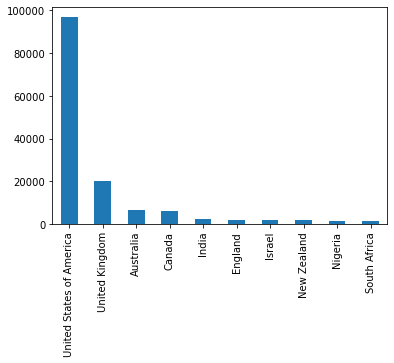

In [47]:
quotes_per_country.head(10).plot.bar()

It is not surprising that quotes that originate from English news articles are mainly from speakers with citizenships from mainly English speaking countires (USA, UK, Australia, Canada etc.), and other countries are clearly underrepresented (from the number of citizens, one would probably assume China and India in the first two places). However, what really surprises us is the huge number of speakers from the US. The relation between US and UK quotes seems reasonable, as there are about 5 times as much quotes and 5 times as much citizens of the US than the UK. The relation between UK and Australia seems to be a bit in favor of the UK, which would normally be a relation of number of citizens of about 2.5, and is more towards 3 here. Among the first 4 places, Canada is clearly underrepresented, having more citizens than Australia but less quotes. 

## Bias in Internet Movie Database ratings:

We also check the (un)biasedness of our second potentially biased dataset: The ratings from IMDb. Here, we check for a bias both in terms of gender and in terms of age groups. Let's see, how much influence majority groups in both properties might have on the total perception of a movie.

For our analysis, we were a bit limited by our dataset. The main problem is, that we only get a mean vote and the number of votes per group (e.g. male/female, age < 18, 18 to 30, ...). We are clearly missing a standard diviation here to make statistically valid statements about these topics in general. However, it is still possible for us to reason on a movie-by-movie basis.

We were trying to find other datasets, however, very few datasets (except for Quotebank and the imdb set) give information about the gender, ethnicity, age, etc. of a person. Our strongest candidate was the movielens dataset, but which only covers this information in a dataset with ratings from before 2003. 

In [48]:
movies = pd.read_csv('exploratory/data/IMDb/IMDb movies.csv')

/opt/miniconda3/envs/ada/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [49]:
ratings = pd.read_csv('exploratory/data/IMDb/IMDb ratings.csv')

In [50]:
def clean_imdb(df):
    imdb = df.rename(columns = {'worlwide_gross_income':'worldwide_gross_income'})
    imdb = imdb.drop(imdb.index[83917])
    imdb['year'] = imdb['year'].astype(int)
    imdb = imdb[imdb['year']>2014]
    imdb = imdb.dropna()
    imdb['budget'] = imdb['budget'].map(lambda x: x.lstrip('$EURCZKNYGBPWILSADMXNJPYOP')).astype(int)
    imdb['worldwide_gross_income'] = imdb['worldwide_gross_income'].map(lambda x: x.lstrip('$EURCZKNYGBPWILSADMXNJPYOP')).astype(int)
    imdb['usa_gross_income'] = imdb['usa_gross_income'].map(lambda x: x.lstrip('$EURCZKNYGBPWILSADMXNJPYOP')).astype(int)
    imdb['date_published'] = pd.to_datetime(imdb['date_published'])
    return imdb

movies = clean_imdb(movies)

In [51]:
def standardize_col(col):
    try:
        return (col - col.mean())/col.std()
    except:
        return col

In [52]:
movies.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worldwide_gross_income,metascore,reviews_from_users,reviews_from_critics
43822,tt0369610,Jurassic World,Jurassic World,2015,2015-06-11,"Action, Adventure, Sci-Fi",124,USA,English,Colin Trevorrow,...,"Chris Pratt, Bryce Dallas Howard, Irrfan Khan,...","A new theme park, built on the original site o...",7.0,569512,150000000,652270625,1670401444,59.0,1537.0,698.0
44619,tt0385887,Motherless Brooklyn - I segreti di una città,Motherless Brooklyn,2019,2019-11-07,"Crime, Drama, Mystery",144,USA,"English, French",Edward Norton,...,"Edward Norton, Gugu Mbatha-Raw, Alec Baldwin, ...","In 1950s New York, a lonely private detective ...",6.8,34759,26000000,9277736,18477736,60.0,319.0,178.0
46723,tt0437086,Alita - Angelo della battaglia,Alita: Battle Angel,2019,2019-02-14,"Action, Adventure, Sci-Fi",122,"USA, Japan, Canada","English, Spanish",Robert Rodriguez,...,"Rosa Salazar, Christoph Waltz, Jennifer Connel...","A deactivated cyborg is revived, but cannot re...",7.3,217183,170000000,85710210,404852543,53.0,2757.0,368.0
47132,tt0448115,Shazam!,Shazam!,2019,2019-04-03,"Action, Adventure, Comedy",132,"USA, Canada","English, Spanish",David F. Sandberg,...,"Zachary Levi, Mark Strong, Asher Angel, Jack D...",A newly fostered young boy in search of his mo...,7.1,240858,100000000,140371656,365971656,71.0,2009.0,379.0
47292,tt0451279,Wonder Woman,Wonder Woman,2017,2017-06-01,"Action, Adventure, Fantasy",141,"USA, China, Hong Kong","English, German, Dutch, French, Spanish, Chine...",Patty Jenkins,...,"Gal Gadot, Chris Pine, Connie Nielsen, Robin W...",When a pilot crashes and tells of conflict in ...,7.4,535903,149000000,412563408,821847012,76.0,2200.0,713.0


In [53]:
ratings.head()

,imdb_title_id,weighted_average_vote,total_votes,mean_vote,median_vote,votes_10,votes_9,votes_8,votes_7,votes_6,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0000009,5.9,154,5.9,6.0,12,4,10,43,28,...,5.7,13.0,4.5,4.0,5.7,34.0,6.4,51.0,6.0,70.0
1,tt0000574,6.1,589,6.3,6.0,57,18,58,137,139,...,6.2,23.0,6.6,14.0,6.4,66.0,6.0,96.0,6.2,331.0
2,tt0001892,5.8,188,6.0,6.0,6,6,17,44,52,...,5.8,4.0,6.8,7.0,5.4,32.0,6.2,31.0,5.9,123.0
3,tt0002101,5.2,446,5.3,5.0,15,8,16,62,98,...,5.5,14.0,6.1,21.0,4.9,57.0,5.5,207.0,4.7,105.0
4,tt0002130,7.0,2237,6.9,7.0,210,225,436,641,344,...,7.3,82.0,7.4,77.0,6.9,139.0,7.0,488.0,7.0,1166.0


In [54]:
imdb = movies.merge(ratings, on='imdb_title_id')
imdb.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0369610,Jurassic World,Jurassic World,2015,2015-06-11,"Action, Adventure, Sci-Fi",124,USA,English,Colin Trevorrow,...,7.2,32243.0,7.3,6381.0,6.8,762.0,7.1,72876.0,6.8,217418.0
1,tt0385887,Motherless Brooklyn - I segreti di una città,Motherless Brooklyn,2019,2019-11-07,"Crime, Drama, Mystery",144,USA,"English, French",Edward Norton,...,6.8,1632.0,7.1,837.0,6.3,269.0,6.8,5124.0,6.8,14796.0
2,tt0437086,Alita - Angelo della battaglia,Alita: Battle Angel,2019,2019-02-14,"Action, Adventure, Sci-Fi",122,"USA, Japan, Canada","English, Spanish",Robert Rodriguez,...,7.2,7651.0,7.5,1843.0,6.8,439.0,7.3,22680.0,7.2,83787.0
3,tt0448115,Shazam!,Shazam!,2019,2019-04-03,"Action, Adventure, Comedy",132,"USA, Canada","English, Spanish",David F. Sandberg,...,7.1,8995.0,7.3,2091.0,6.8,525.0,7.3,28394.0,6.9,85782.0
4,tt0451279,Wonder Woman,Wonder Woman,2017,2017-06-01,"Action, Adventure, Fantasy",141,"USA, China, Hong Kong","English, German, Dutch, French, Spanish, Chine...",Patty Jenkins,...,7.6,29053.0,7.8,7220.0,7.0,723.0,7.7,67709.0,7.2,190337.0


In [55]:
relevant_years = imdb[imdb['year'].isin(list(range(2015, 2021)))]
relevant_years.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0369610,Jurassic World,Jurassic World,2015,2015-06-11,"Action, Adventure, Sci-Fi",124,USA,English,Colin Trevorrow,...,7.2,32243.0,7.3,6381.0,6.8,762.0,7.1,72876.0,6.8,217418.0
1,tt0385887,Motherless Brooklyn - I segreti di una città,Motherless Brooklyn,2019,2019-11-07,"Crime, Drama, Mystery",144,USA,"English, French",Edward Norton,...,6.8,1632.0,7.1,837.0,6.3,269.0,6.8,5124.0,6.8,14796.0
2,tt0437086,Alita - Angelo della battaglia,Alita: Battle Angel,2019,2019-02-14,"Action, Adventure, Sci-Fi",122,"USA, Japan, Canada","English, Spanish",Robert Rodriguez,...,7.2,7651.0,7.5,1843.0,6.8,439.0,7.3,22680.0,7.2,83787.0
3,tt0448115,Shazam!,Shazam!,2019,2019-04-03,"Action, Adventure, Comedy",132,"USA, Canada","English, Spanish",David F. Sandberg,...,7.1,8995.0,7.3,2091.0,6.8,525.0,7.3,28394.0,6.9,85782.0
4,tt0451279,Wonder Woman,Wonder Woman,2017,2017-06-01,"Action, Adventure, Fantasy",141,"USA, China, Hong Kong","English, German, Dutch, French, Spanish, Chine...",Patty Jenkins,...,7.6,29053.0,7.8,7220.0,7.0,723.0,7.7,67709.0,7.2,190337.0


In [56]:
relevant_years_stdz = relevant_years.apply(standardize_col, axis=0)
relevant_years_stdz.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0369610,Jurassic World,Jurassic World,-1.294172,-1.536841,"Action, Adventure, Sci-Fi",0.825079,USA,English,Colin Trevorrow,...,0.790351,4.058516,0.775531,3.418174,1.123500,2.733679,0.702649,4.208965,0.515443,3.712219
1,tt0385887,Motherless Brooklyn - I segreti di una città,Motherless Brooklyn,1.466543,1.511622,"Crime, Drama, Mystery",2.011445,USA,"English, French",Edward Norton,...,0.330721,-0.544581,0.545030,-0.317413,0.574413,-0.194279,0.381114,-0.396925,0.515443,-0.444035
2,tt0437086,Alita - Angelo della battaglia,Alita: Battle Angel,1.466543,1.007963,"Action, Adventure, Sci-Fi",0.706443,"USA, Japan, Canada","English, Spanish",Robert Rodriguez,...,0.790351,0.360520,1.006031,0.360437,1.123500,0.815362,0.917006,0.796560,0.951976,0.971133
3,tt0448115,Shazam!,Shazam!,1.466543,1.098849,"Action, Adventure, Comedy",1.299625,"USA, Canada","English, Spanish",David F. Sandberg,...,0.675443,0.562623,0.775531,0.527541,1.123500,1.326121,0.917006,1.185007,0.624576,1.012055
4,tt0451279,Wonder Woman,Wonder Woman,0.086185,-0.171660,"Action, Adventure, Fantasy",1.833490,"USA, China, Hong Kong","English, German, Dutch, French, Spanish, Chine...",Patty Jenkins,...,1.249981,3.578824,1.351782,3.983498,1.343135,2.502056,1.345719,3.857704,0.951976,3.156724


First, we check the distribution among mean percentages of male voters per movie. 

0.5802392635264324

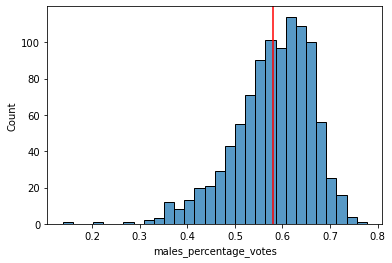

In [57]:
relevant_years['males_percentage_votes'] = relevant_years['males_allages_votes'] / relevant_years['votes']
#relevant_years['males_percentage_votes'].plot.hist(bins=50)
sns.histplot(data=relevant_years, x='males_percentage_votes')
plt.axvline(x=relevant_years['males_percentage_votes'].mean(),
            color='red')
relevant_years['males_percentage_votes'].mean()

We observe a slightly left-skewed distribution, with a mean of .58, while we would expect a mean of 0.5. 
We can therefore test whether the mean of 0.58 is significantly different from 0.5, which we consider the distribution of male and females in the world (our population). For this, the two-sided 1-sample ttest is a perfect match.

In [58]:
ttest_1samp(relevant_years['males_percentage_votes'], 0.5)

Ttest_1sampResult(statistic=30.859035907939063, pvalue=4.013537684447491e-147)

The p value let's us reject the Null Hypothesis that females and males are equally (50 % each) in the number of ratings. Hence, the averages tend to cover more male reviewers than female reviewers. We would derive from this result that average scores might be biased towards male opinions. 

Let's have a look at the left and right extremes, just to see what kinds of movies that might be. It looks like there are 3 movies with very low male percentage and 1-5 with a very high. So, we just have a look at the 5 highest and lowest percentage of male votes.

In [59]:
relevant_years[['original_title','males_percentage_votes']].sort_values('males_percentage_votes').head(5)

,original_title,males_percentage_votes
566,Meet the Blacks,0.137320
552,After,0.215840
706,"Everything, Everything",0.278886
548,Forever My Girl,0.327401
855,The Sun Is Also a Star,0.328246


In [60]:
relevant_years[['original_title','males_percentage_votes']].sort_values('males_percentage_votes', ascending=False).head(5)

,original_title,males_percentage_votes
500,Mai sing,0.777633
279,The Gunman,0.748229
466,Turbo Kid,0.746878
730,Kickboxer: Retaliation,0.739533
502,Cop Car,0.736558


## How successful are movies liked by men/women?

As a first step, we analyze the influence of the average vote by men and women on the total mean. For this, we fit an OLS model to predict the total mean and have a look at the coefficients. 

In [61]:
mod = smf.ols(formula='mean_vote ~ females_allages_avg_vote + males_allages_avg_vote', data=relevant_years_stdz)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              mean_vote   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     8391.
Date:                Fri, 17 Dec 2021   Prob (F-statistic):               0.00
Time:                        01:16:48   Log-Likelihood:                 25.248
No. Observations:                 993   AIC:                            -44.50
Df Residuals:                     990   BIC:                            -29.79
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In this case, we see a strong influence of both averages. We would deduce that both averages have significant influence on the total mean of votes for a movie. 

In [62]:
pearsonr(relevant_years['females_allages_avg_vote'], relevant_years['mean_vote'])

(0.9512413209555082, 0.0)

In [63]:
pearsonr(relevant_years['males_allages_avg_vote'], relevant_years['mean_vote'])

(0.9559658322414973, 0.0)

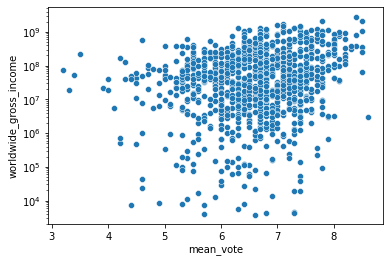

In [64]:
ax = sns.scatterplot(x='mean_vote', y='worldwide_gross_income', data=relevant_years)
ax.set(yscale='log');

From this plot, we see no direct correlation between the mean vote of a movie and its success in terms of income (a shame...). We would therefore argue that the income of a movie is also independent of the average vote by male and female reviewers. For completeness, we also add the two plots with male and female average votes, underlying our hypothesis:

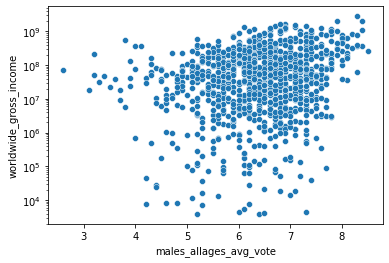

In [65]:
ax = sns.scatterplot(x='males_allages_avg_vote', y='worldwide_gross_income', data=relevant_years)
ax.set(yscale='log');

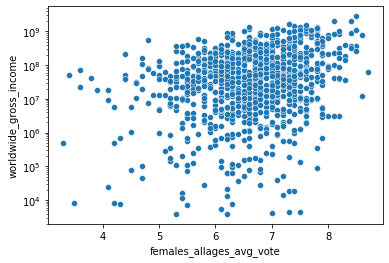

In [66]:
ax = sns.scatterplot(x='females_allages_avg_vote', y='worldwide_gross_income', data=relevant_years)
ax.set(yscale='log');

## Average vote by men?

Let's see if the trend from the quotebank data is agreed on here: That men are on average giving lower scores than women. The distribution of average votes on movies by men or women might indicate so. 

Let us be very clear with the hypothesis to check here: We want to check whether the mean rating score on a movie is significantlly different between female and male voters. 

In [67]:
ratings['males_allages_avg_vote'].mean()

5.817172176019604

In [68]:
ratings['females_allages_avg_vote'].mean()

6.0394082122788

<AxesSubplot:ylabel='Frequency'>

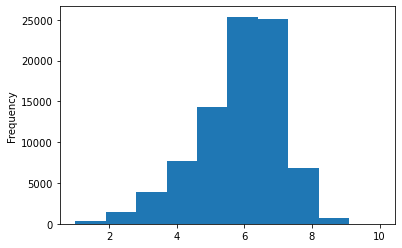

In [69]:
ratings['males_allages_avg_vote'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

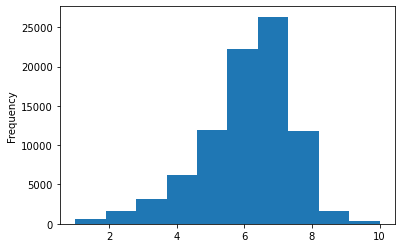

In [70]:
ratings['females_allages_avg_vote'].plot.hist()

6.355991943605238

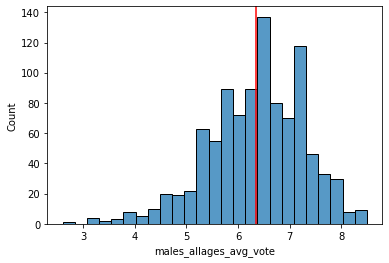

In [71]:
sns.histplot(data=relevant_years, x='males_allages_avg_vote')
plt.axvline(x=relevant_years['males_allages_avg_vote'].mean(),
            color='red')
relevant_years['males_allages_avg_vote'].mean()

6.598791540785492

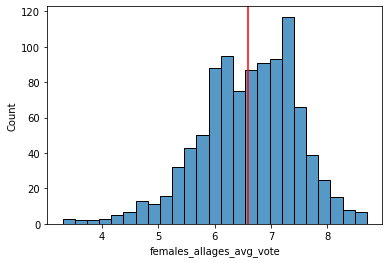

In [72]:
sns.histplot(data=relevant_years, x='females_allages_avg_vote')
plt.axvline(x=relevant_years['females_allages_avg_vote'].mean(),
            color='red')
relevant_years['females_allages_avg_vote'].mean()

Set equal_var to False to not assume that both distributions have an equal variance.

In [73]:
ttest_ind(relevant_years['males_allages_avg_vote'], relevant_years['females_allages_avg_vote'], equal_var=False)

Ttest_indResult(statistic=-6.004186697377894, pvalue=2.282261102655337e-09)

Our test shows us that with high probability, we can reject the null hypothesis that the avg votes of male and female voters per movie are on expectation the same. Hence, we conclude that they the average vote per movie by men is on average lower than by women. N.b. that this does not say anything about single votes, just about this summary statistic of groups of votes. 

## Young vs old generation? Which generation influences movie success the most?

As last, we assess if there are age groups that have more influence on the topic than others. We first check the influence of these on the total mean per movie by fitting linear regression and checking the coefficients.
We see that among all voters, people between 18 and 30 (allgenders_18age_votes) and people between 30 and 45 (allgenders_30age_votes) make up for the majority of voters in total. Also, as seen from all histograms over all movies, we can see that for a big number of movies, the groups of 18-30 or 30-45 years old are the majority of voters.

In [74]:
relevant_years = relevant_years.dropna(subset=['allgenders_0age_votes','allgenders_18age_votes','allgenders_30age_votes','allgenders_45age_votes'])

In [75]:
for col_name in ['allgenders_0age_votes','allgenders_18age_votes','allgenders_30age_votes','allgenders_45age_votes']:
    print('{}: {}'.format(col_name, sum(relevant_years[col_name])))

allgenders_0age_votes: 128347.0
allgenders_18age_votes: 20265886.0
allgenders_30age_votes: 31377048.0
allgenders_45age_votes: 8367419.0


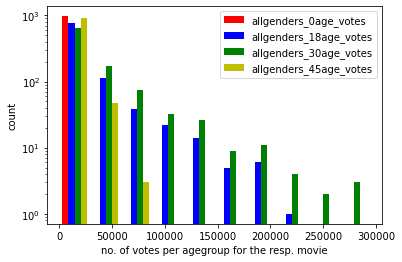

In [76]:
col_names = ['allgenders_0age_votes','allgenders_18age_votes','allgenders_30age_votes','allgenders_45age_votes']
plt.hist([relevant_years[col_name] for col_name in col_names], color=['r','b', 'g', 'y'], log=True, label=col_names)
plt.legend()
plt.ylabel('count')
plt.xlabel('no. of votes per agegroup for the resp. movie');

In [77]:
mod = smf.ols(formula='mean_vote ~ allgenders_0age_avg_vote + allgenders_18age_avg_vote + allgenders_30age_avg_vote + allgenders_45age_avg_vote', data=relevant_years_stdz)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              mean_vote   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     3641.
Date:                Fri, 17 Dec 2021   Prob (F-statistic):               0.00
Time:                        01:16:51   Log-Likelihood:                -23.888
No. Observations:                 969   AIC:                             57.78
Df Residuals:                     964   BIC:                             82.16
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

However, when taking a look at the linear regression model to predict the total mean of votes from the mean in each agegroup, it turns out that only 18-30 years old and 45 and older have a significant influence on the mean of all votes. While we would expect such a result for the (highly underrepresented, only 40k Votes in total) group of < 18 years old, we are very surprised that the group of 30-45 years old has no significant influence on the overall rating of the movie. 

<AxesSubplot:xlabel='allgenders_30age_avg_vote', ylabel='mean_vote'>

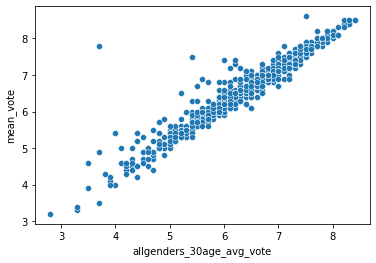

In [78]:
sns.scatterplot(x='allgenders_30age_avg_vote', y='mean_vote', data=relevant_years)

<AxesSubplot:xlabel='allgenders_0age_avg_vote', ylabel='mean_vote'>

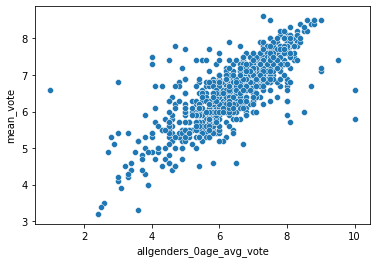

In [79]:
sns.scatterplot(x='allgenders_0age_avg_vote', y='mean_vote', data=relevant_years)

In [80]:
pearsonr(relevant_years['allgenders_30age_avg_vote'], relevant_years['mean_vote'])

(0.9622909030010768, 0.0)

In [81]:
pearsonr(relevant_years['allgenders_0age_avg_vote'].fillna(0), relevant_years['mean_vote'])

(0.7848627334906555, 3.411836972143402e-203)

For these two groups, we further investigate their influence on the mean. For both, we get high values of pearson r, with a nearly 1 value for the group between 30 and 45. We might deduce the following: The group of 30-45 seems to be closely following the average vote, being about on the same level. However, high average means are only achieved when either 18-30 or 45+ ages vote good on movies, at least on average for single movies. 